<a href="https://colab.research.google.com/github/MartaGacek1/MonteCarloProject1/blob/main/MonteCarloProjekt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt I - Wprowadzenie do symulacji i metod Monte Carlo

## Marta Gacek

## 1. Generatory liczb pseudolosowych

### 1.1 LCG ("Linear Congruential Generator")



In [78]:
import time

# x0 - warunek początkowy
# M - wartość modulo
# a, c - parametry z rekurencyjnego wzoru
# n - ilość liczb pseudolosowych, które otrzymamy

def LCG(x0, a, c, M, n):
    result = []
    x = x0 % M
    result.append(x)
    for i in range(n-1):
        x = (a * x + c) % M
        result.append(x)
    return [j/M for j in result]

start_time = time.time()
test_lcg=LCG(30, 1, 5, 13, 2**15)
end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")
#print(test_lcg)

Czas wykonania: 0.008825 sekund


### 1.2 GLCG ("Generalized Linear Congruential Generator")

In [79]:
# liczba współczynników musi być równa k, czyli liczbie wartości początkowych x_i dla i=0,...,k-1
# initials - lista k warunków początkowych
# coeffs - współczynniki a_i dla i=0,...,k-1
# M - wartość modulo
# n - ilość liczb pseudolosowych, które otrzymamy

def GLCG(initials, coeffs, M, n):
    k = len(initials)
    if len(coeffs) != k:
        raise ValueError("The number of coefficients doesn't match the number of initial values.")
    lst = initials[:] # lista "robocza"
    result = lst[:] # tutaj będą ostatecznie zwracane liczby
    result = [i/M for i in result] # normalizacja
    for i in range(n - k): # bo pierwsze k z n liczb już mamy na początku
        x = sum(coeffs[j] * lst[-(j + 1)] for j in range(k)) % M
        result.append(x/M) # normalizacja
        lst.append(x)
        lst.pop(0)  # potrzebujemy k ostatnich wartości do wyznaczania następnych x
    return result

start_time = time.time()
test_glcg=GLCG([30, 40, 50], [3, 7, 68], 2**10, 2**15)
end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")
#print(test_glcg)

Czas wykonania: 0.079768 sekund


### 1.3 RC4

In [80]:
# K - "klucz" - liczby z przedziału {0,...,m-1}, w naszym przypadku m=32
# n - ilość liczb pseudolosowych, które otrzymamy
# S - permutacja zbioru m-elementowego
# m - wartość modulo

import matplotlib.pyplot as plt
import random as rd
import numpy as np

def KSA(K, m=32):
   S = list(range(m))
   j = 0
   for i in range(m):
       j = (j + S[i] + K[i % len(K)]) % m
       S[i], S[j] = S[j], S[i]
   return S

def PRGA(S, n, m=32):
   i = 0
   j = 0
   result = []
   for k in range(n):
       i = (i + 1) % m
       j = (j + S[i]) % m
       S[i], S[j] = S[j], S[i]
       Y = S[(S[i] + S[j]) % m]
       result.append(Y/m) # normalizacja
   return result

def RC4(K, n, m=32):
  s = KSA(K, m)
  return PRGA(s, n, m)


k1 = [x for x in range(100)]
start_time = time.time()
test_rc4 = RC4(k1, 2**15)
end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")
#print(test_rc4)

Czas wykonania: 0.016029 sekund


### 1.4 Xorshift

In [81]:
# x0 - niezerowy warunek początkowy
# a, b, c - parametry określające przesunięcia bitowe
# n - ilość liczb pseudolosowych, które otrzymamy

def xorshift(x0, n, a=21, b=35, c=4):
    if x0 == 0:
        raise ValueError("Initial value must not be zero.")
    x = x0
    result = []
    for i in range(n):
        x ^= (x >> a)  # przesunięcie w prawo i operacja xor
        x ^= (x << b)  # przesunięcie w lewo i operacja xor
        x ^= (x >> c)  # przesunięcie w prawo i operacja xor
        result.append(x & 0xFFFFFFFF)  # ograniczenie liczby x do zakresu 32-bitowego
    result = [i/(2**32 - 1) for i in result] # normalizacja (dzielimy przez największą możliwą wartość wygenerowaną przez xorshift)
    return result

start_time = time.time()
test_xorshift = xorshift(20, n=2**15)
end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")
#print(test_xorshift)

Czas wykonania: 5.623842 sekund


# 2. Testy statystyczne

## 2.1 Test $\chi^2$

In [94]:
from scipy.stats import chisquare

# wyniki dla n = 2^15

start_time = time.time()

# LCG

binss=20

obs1, edges = np.histogram(test_lcg, bins=binss)
expt1 = np.full(binss, len(test_lcg) / binss)
st1, p1 = chisquare(f_obs=obs1, f_exp=expt1)
print("Statystyka chi-kwadrat dla LCG:", st1)
print("P-wartość dla LCG:", p1)

# GLCG

obs2, edges = np.histogram(test_glcg, bins=binss)
expt2 = np.full(binss, len(test_glcg) / binss)
st2, p2 = chisquare(f_obs=obs2, f_exp=expt2)
print("Statystyka chi-kwadrat dla GLCG:", st2)
print("P-wartość dla GLCG:", p2)

# RC4

obs3, edges = np.histogram(test_rc4, bins=binss)
expt3 = np.full(binss, len(test_rc4) / binss)
st3, p3 = chisquare(f_obs=obs3, f_exp=expt3)
print("Statystyka chi-kwadrat dla RC4:", st3)
print("P-wartość dla RC4:", p3)

# Xorshift

obs4, edges = np.histogram(test_xorshift, bins=binss)
expt4 = np.full(binss, len(test_xorshift) / binss)
st4, p4 = chisquare(f_obs=obs4, f_exp=expt4)
print("Statystyka chi-kwadrat dla Xorshift:", st4)
print("P-wartość dla Xorshift:", p4)

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")


Statystyka chi-kwadrat dla LCG: 17644.309570312504
P-wartość dla LCG: 0.0
Statystyka chi-kwadrat dla GLCG: 5505.256835937498
P-wartość dla GLCG: 0.0
Statystyka chi-kwadrat dla RC4: 3149.357177734375
P-wartość dla RC4: 0.0
Statystyka chi-kwadrat dla Xorshift: 17.54443359375
P-wartość dla Xorshift: 0.5530346658651297
Czas wykonania: 0.031397 sekund


In [99]:
# wyniki dla n = 2^10

start_time = time.time()

test_lcg1=LCG(30, 1, 5, 13, 2**10)
test_glcg1=GLCG([30, 40, 50], [3, 7, 68], 2**10, 2**10)
test_rc4_1 = RC4(k1, 2**10)
test_xorshift1 = xorshift(20, n=2**10)

# LCG

binss=20

obs1, edges = np.histogram(test_lcg1, bins=binss)
expt1 = np.full(binss, len(test_lcg1) / binss)
st1, p1 = chisquare(f_obs=obs1, f_exp=expt1)
print("Statystyka chi-kwadrat dla LCG:", st1)
print("P-wartość dla LCG:", p1)

# GLCG

obs2, edges = np.histogram(test_glcg1, bins=binss)
expt2 = np.full(binss, len(test_glcg1) / binss)
st2, p2 = chisquare(f_obs=obs2, f_exp=expt2)
print("Statystyka chi-kwadrat dla GLCG:", st2)
print("P-wartość dla GLCG:", p2)

# RC4

obs3, edges = np.histogram(test_rc4_1, bins=binss)
expt3 = np.full(binss, len(test_rc4_1) / binss)
st3, p3 = chisquare(f_obs=obs3, f_exp=expt3)
print("Statystyka chi-kwadrat dla RC4:", st3)
print("P-wartość dla RC4:", p3)

# Xorshift

obs4, edges = np.histogram(test_xorshift1, bins=binss)
expt4 = np.full(binss, len(test_xorshift1) / binss)
st4, p4 = chisquare(f_obs=obs4, f_exp=expt4)
print("Statystyka chi-kwadrat dla Xorshift:", st4)
print("P-wartość dla Xorshift:", p4)

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")


Statystyka chi-kwadrat dla LCG: 551.4296875000001
P-wartość dla LCG: 8.69783778595415e-105
Statystyka chi-kwadrat dla GLCG: 171.23437499999994
P-wartość dla GLCG: 1.62888195715364e-26
Statystyka chi-kwadrat dla RC4: 122.2109375
P-wartość dla RC4: 4.2763370025242595e-17
Statystyka chi-kwadrat dla Xorshift: 11.742187500000004
P-wartość dla Xorshift: 0.8963475736552577
Czas wykonania: 0.021904 sekund


In [98]:
# wyniki dla n = 2^20
# z wyjątkiem Xorshift, bo dla większych rozmiarów n wykonuje się on bardzo wolno (dla 2^20 ponad 1h 20 min)

start_time = time.time()

test_lcg2=LCG(30, 1, 5, 13, 2**20)
test_glcg2=GLCG([30, 40, 50], [3, 7, 68], 2**10, 2**20)
test_rc4_2 = RC4(k1, 2**20)
#test_xorshift2 = xorshift(20, n=2**20)

# LCG

binss=20

obs1, edges = np.histogram(test_lcg2, bins=binss)
expt1 = np.full(binss, len(test_lcg2) / binss)
st1, p1 = chisquare(f_obs=obs1, f_exp=expt1)
print("Statystyka chi-kwadrat dla LCG:", st1)
print("P-wartość dla LCG:", p1)

# GLCG

obs2, edges = np.histogram(test_glcg2, bins=binss)
expt2 = np.full(binss, len(test_glcg2) / binss)
st2, p2 = chisquare(f_obs=obs2, f_exp=expt2)
print("Statystyka chi-kwadrat dla GLCG:", st2)
print("P-wartość dla GLCG:", p2)

# RC4

obs3, edges = np.histogram(test_rc4_2, bins=binss)
expt3 = np.full(binss, len(test_rc4_2) / binss)
st3, p3 = chisquare(f_obs=obs3, f_exp=expt3)
print("Statystyka chi-kwadrat dla RC4:", st3)
print("P-wartość dla RC4:", p3)

# Xorshift

obs4, edges = np.histogram(test_xorshift, bins=binss)
expt4 = np.full(binss, len(test_xorshift) / binss)
st4, p4 = chisquare(f_obs=obs4, f_exp=expt4)
print("Statystyka chi-kwadrat dla Xorshift:", st4)
print("P-wartość dla Xorshift:", p4)

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Statystyka chi-kwadrat dla LCG: 564617.8462066652
P-wartość dla LCG: 0.0
Statystyka chi-kwadrat dla GLCG: 176239.7649993896
P-wartość dla GLCG: 0.0
Statystyka chi-kwadrat dla RC4: 98795.03034973145
P-wartość dla RC4: 0.0
Statystyka chi-kwadrat dla Xorshift: 17.54443359375
P-wartość dla Xorshift: 0.5530346658651297
Czas wykonania: 2.287854 sekund


## 2.2 Test Kołmogorowa-Smirnowa

In [100]:
from scipy.stats import ks_1samp, uniform

# wyniki dla n = 2^15

start_time = time.time()

# LCG

st1, p1 = ks_1samp(test_lcg, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla LCG:", st1)
print("P-wartość dla LCG:", p1)

# GLCG

st2, p2 = ks_1samp(test_glcg, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla GLCG:", st2)
print("P-wartość dla GLCG:", p2)

# RC4
#dziwne wyniki bo dystrybuanta schodkowa

st3, p3 = ks_1samp(test_rc4, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla RC4:", st3)
print("P-wartość dla RC4:", p3)

# Xorshift

st4, p4 = ks_1samp(test_xorshift, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla Xorshift:", st4)
print("P-wartość dla Xorshift:", p4)

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Statystyka Kołmogorowa-Smirnowa dla LCG: 0.07695124699519229
P-wartość dla LCG: 3.313269529534475e-169
Statystyka Kołmogorowa-Smirnowa dla GLCG: 0.073516845703125
P-wartość dla GLCG: 1.8473544790399517e-154
Statystyka Kołmogorowa-Smirnowa dla RC4: 0.033294677734375
P-wartość dla RC4: 5.404678627545136e-32
Statystyka Kołmogorowa-Smirnowa dla Xorshift: 0.005506766648966599
P-wartość dla Xorshift: 0.2724178392024802
Czas wykonania: 0.156151 sekund


In [101]:
# wyniki dla n = 2^10

start_time = time.time()

# LCG

st1, p1 = ks_1samp(test_lcg1, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla LCG:", st1)
print("P-wartość dla LCG:", p1)

# GLCG

st2, p2 = ks_1samp(test_glcg1, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla GLCG:", st2)
print("P-wartość dla GLCG:", p2)

# RC4
#dziwne wyniki bo dystrybuanta schodkowa

st3, p3 = ks_1samp(test_rc4_1, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla RC4:", st3)
print("P-wartość dla RC4:", p3)

# Xorshift

st4, p4 = ks_1samp(test_xorshift1, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla Xorshift:", st4)
print("P-wartość dla Xorshift:", p4)

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Statystyka Kołmogorowa-Smirnowa dla LCG: 0.07767427884615385
P-wartość dla LCG: 8.058011247917728e-06
Statystyka Kołmogorowa-Smirnowa dla GLCG: 0.0712890625
P-wartość dla GLCG: 5.7016213355827625e-05
Statystyka Kołmogorowa-Smirnowa dla RC4: 0.044921875
P-wartość dla RC4: 0.031098686325928604
Statystyka Kołmogorowa-Smirnowa dla Xorshift: 0.02057039097327651
P-wartość dla Xorshift: 0.7710172549602066
Czas wykonania: 0.018169 sekund


In [102]:
# wyniki dla n = 2^20
# z wyjątkiem Xorshift

start_time = time.time()

# LCG

st1, p1 = ks_1samp(test_lcg2, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla LCG:", st1)
print("P-wartość dla LCG:", p1)

# GLCG

st2, p2 = ks_1samp(test_glcg2, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla GLCG:", st2)
print("P-wartość dla GLCG:", p2)

# RC4
#dziwne wyniki bo dystrybuanta schodkowa

st3, p3 = ks_1samp(test_rc4_2, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla RC4:", st3)
print("P-wartość dla RC4:", p3)

# Xorshift

st4, p4 = ks_1samp(test_xorshift, uniform.cdf)
print("Statystyka Kołmogorowa-Smirnowa dla Xorshift:", st4)
print("P-wartość dla Xorshift:", p4)

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Statystyka Kołmogorowa-Smirnowa dla LCG: 0.0769241773165189
P-wartość dla LCG: 0.0
Statystyka Kołmogorowa-Smirnowa dla GLCG: 0.07356548309326172
P-wartość dla GLCG: 0.0
Statystyka Kołmogorowa-Smirnowa dla RC4: 0.03149986267089844
P-wartość dla RC4: 0.0
Statystyka Kołmogorowa-Smirnowa dla Xorshift: 0.005506766648966599
P-wartość dla Xorshift: 0.2724178392024802
Czas wykonania: 0.494472 sekund


## 2.3 Test serii

In [72]:
import numpy as np
from scipy.stats import norm

def runs_test(data):
    median = np.median(data)
    binary = [1 if i >= median else 0 for i in data]  # zamiana danych na ciąg binarny (według mediany)
    x = np.sum(binary)  # Liczba 1 (liczenie elementów)
    y = len(binary) - x  # Liczba 0
    n = x + y
    if x == 0 or y == 0:
        raise ValueError("Not enough diversity of data. We cannot perform this test.")
    runs = 1  # liczba serii
    for i in range(1, len(binary)):
        if binary[i] != binary[i - 1]:
            runs += 1
    expected = (2 * x * y) / n + 1  # wartość oczekiwana liczby serii
    sigma = np.sqrt((2 * x * y * (2 * x * y - n)) / (n**2 * (n - 1)))  # odchylenie standardowe
    z = (runs - expected) / sigma
    p_value = 2 * (1 - norm.cdf(abs(z)))                   # czy trzeba zmieniać na uniform?
    return {
        "Statystyka Z": z,
        "P-wartość": p_value,
        "Liczba serii": runs,
        "Mediana": median
    }

In [103]:
# wyniki dla n = 2^15

start_time = time.time()

# LCG

lcg_data = runs_test(test_lcg)
print("Statystyka testu serii dla LCG:", lcg_data["Statystyka Z"])
print("P-wartość dla LCG:", lcg_data["P-wartość"])

# GLCG

glcg_data = runs_test(test_glcg)
print("Statystyka testu serii dla GLCG:", glcg_data["Statystyka Z"])
print("P-wartość dla GLCG:", glcg_data["P-wartość"])

# RC4

rc4_data = runs_test(test_rc4)
print("Statystyka testu serii dla RC4:", rc4_data["Statystyka Z"])
print("P-wartość dla RC4:", rc4_data["P-wartość"])

# Xorshift

xorshift_data = runs_test(test_xorshift)
print("Statystyka testu serii dla Xorshift:", xorshift_data["Statystyka Z"])
print("P-wartość dla Xorshift:", xorshift_data["P-wartość"])

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Statystyka testu serii dla LCG: 99.12864298977301
P-wartość dla LCG: 0.0
Statystyka testu serii dla GLCG: -7.502074837193712
P-wartość dla GLCG: 6.283862319378386e-14
Statystyka testu serii dla RC4: 1.1924843866469046
P-wartość dla RC4: 0.23307136924221683
Statystyka testu serii dla Xorshift: 0.7955072677755272
P-wartość dla Xorshift: 0.42631848500068603
Czas wykonania: 0.057789 sekund


In [104]:
# wyniki dla n = 2^10

start_time = time.time()

# LCG

lcg_data = runs_test(test_lcg1)
print("Statystyka testu serii dla LCG:", lcg_data["Statystyka Z"])
print("P-wartość dla LCG:", lcg_data["P-wartość"])

# GLCG

glcg_data = runs_test(test_glcg1)
print("Statystyka testu serii dla GLCG:", glcg_data["Statystyka Z"])
print("P-wartość dla GLCG:", glcg_data["P-wartość"])

# RC4

rc4_data = runs_test(test_rc4_1)
print("Statystyka testu serii dla RC4:", rc4_data["Statystyka Z"])
print("P-wartość dla RC4:", rc4_data["P-wartość"])

# Xorshift

xorshift_data = runs_test(test_xorshift1)
print("Statystyka testu serii dla Xorshift:", xorshift_data["Statystyka Z"])
print("P-wartość dla Xorshift:", xorshift_data["P-wartość"])

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

Statystyka testu serii dla LCG: 17.48320598046148
P-wartość dla LCG: 0.0
Statystyka testu serii dla GLCG: -1.4380864671490048
P-wartość dla GLCG: 0.15040952188240908
Statystyka testu serii dla RC4: -0.7484584845520809
P-wartość dla RC4: 0.45418365728769405
Statystyka testu serii dla Xorshift: 0.43771398876310097
P-wartość dla Xorshift: 0.6615936276613448
Czas wykonania: 0.006741 sekund


In [105]:
# wyniki dla n = 2^20

start_time = time.time()

# LCG

lcg_data = runs_test(test_lcg2)
print("Statystyka testu serii dla LCG:", lcg_data["Statystyka Z"])
print("P-wartość dla LCG:", lcg_data["P-wartość"])

# GLCG

glcg_data = runs_test(test_glcg2)
print("Statystyka testu serii dla GLCG:", glcg_data["Statystyka Z"])
print("P-wartość dla GLCG:", glcg_data["P-wartość"])

# RC4

rc4_data = runs_test(test_rc4_2)
print("Statystyka testu serii dla RC4:", rc4_data["Statystyka Z"])
print("P-wartość dla RC4:", rc4_data["P-wartość"])

# Xorshift

xorshift_data = runs_test(test_xorshift)
print("Statystyka testu serii dla Xorshift:", xorshift_data["Statystyka Z"])
print("P-wartość dla Xorshift:", xorshift_data["P-wartość"])

end_time = time.time()

execution_time = end_time - start_time
print(f"Czas wykonania: {execution_time:.6f} sekund")

<ipython-input-72-c9af52598cfc>:17: RuntimeWarning: overflow encountered in scalar multiply
  sigma = np.sqrt((2 * x * y * (2 * x * y - n)) / (n**2 * (n - 1)))  # odchylenie standardowe
<ipython-input-72-c9af52598cfc>:17: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt((2 * x * y * (2 * x * y - n)) / (n**2 * (n - 1)))  # odchylenie standardowe


Statystyka testu serii dla LCG: nan
P-wartość dla LCG: nan
Statystyka testu serii dla GLCG: nan
P-wartość dla GLCG: nan
Statystyka testu serii dla RC4: nan
P-wartość dla RC4: nan
Statystyka testu serii dla Xorshift: 0.7955072677755272
P-wartość dla Xorshift: 0.42631848500068603
Czas wykonania: 1.156739 sekund


# 3. Second-level testing

In [27]:
import matplotlib.pyplot as plt

#wnioski: czy przechodzą testy 1 i 2 rodzaju

## 3.1 Test $\chi^2$

Text(0.5, 1.0, 'P-wartości dla Xorshift')

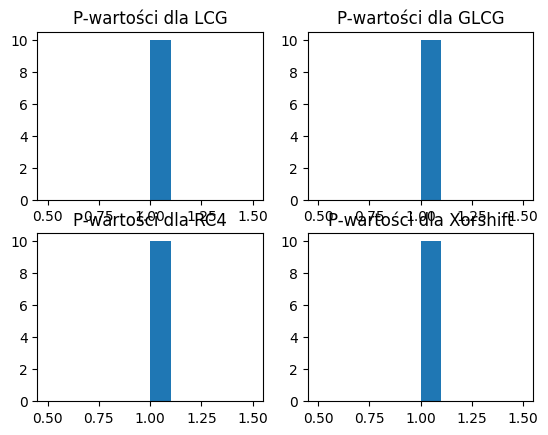

In [45]:
def second_level_testing_chi_square(data, sequence_length):
    seq_num = len(data) // sequence_length  # ilość podciągów podanej długości
    p_values = []
    for i in range(seq_num):
        seq = data[i * sequence_length : (i + 1) * sequence_length]  # tworzenie podciągów
        try:
            p_value = chisquare(seq)[1]  # przeprowadzanie testu
            p_values.append(p_value)
        except ValueError:
            p_values.append(None)
    return p_values


length = 100
p_values1_lcg = second_level_testing_chi_square(test_lcg, length)
p_values1_glcg = second_level_testing_chi_square(test_glcg, length)
p_values1_rc4 = second_level_testing_chi_square(test_rc4, length)
p_values1_xorshift = second_level_testing_chi_square(test_xorshift, length)

# print(f"P-wartości dla wszystkich podciągów - LCG:")
# print(p_values1_lcg)
# print(f"P-wartości dla wszystkich podciągów - GLCG:")
# print(p_values1_glcg)
# print(f"P-wartości dla wszystkich podciągów - RC4:")
# print(p_values1_rc4)
# print(f"P-wartości dla wszystkich podciągów - Xorshift:")
# print(p_values1_xorshift)

plt.subplot(2, 2, 1)
plt.hist(p_values1_lcg)
plt.title("P-wartości dla LCG")

plt.subplot(2, 2, 2)
plt.hist(p_values1_glcg)
plt.title("P-wartości dla GLCG")

plt.subplot(2, 2, 3)
plt.hist(p_values1_rc4)
plt.title("P-wartości dla RC4")

plt.subplot(2, 2, 4)
plt.hist(p_values1_xorshift)
plt.title("P-wartości dla Xorshift")

## 3.2 Test Kołmogorowa-Smirnowa

Text(0.5, 1.0, 'P-wartości dla Xorshift')

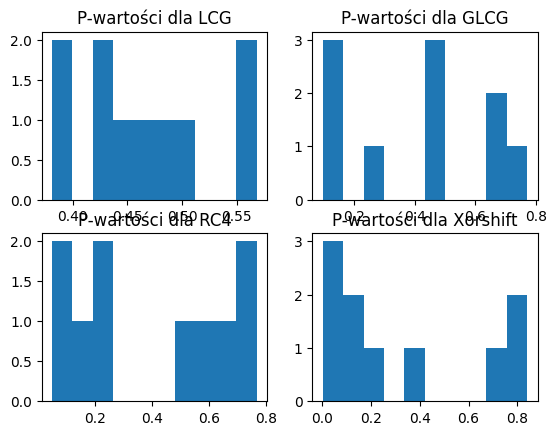

In [44]:
def second_level_testing_ks(data, sequence_length):
    seq_num = len(data) // sequence_length  # ilość podciągów podanej długości
    p_values = []
    for i in range(seq_num):
        seq = data[i * sequence_length : (i + 1) * sequence_length]  # tworzenie podciągów
        try:
            p_value = ks_1samp(seq, uniform.cdf)[1]  # przeprowadzanie testu
            p_values.append(p_value)
        except ValueError:
            p_values.append(None)
    return p_values


length = 100
p_values2_lcg = second_level_testing_ks(test_lcg, length)
p_values2_glcg = second_level_testing_ks(test_glcg, length)
p_values2_rc4 = second_level_testing_ks(test_rc4, length)
p_values2_xorshift = second_level_testing_ks(test_xorshift, length)

# print(f"P-wartości dla wszystkich podciągów - LCG:")
# print(p_values2_lcg)
# print(f"P-wartości dla wszystkich podciągów - GLCG:")
# print(p_values2_glcg)
# print(f"P-wartości dla wszystkich podciągów - RC4:")
# print(p_values2_rc4)
# print(f"P-wartości dla wszystkich podciągów - Xorshift:")
# print(p_values2_xorshift)

plt.subplot(2, 2, 1)
plt.hist(p_values2_lcg)
plt.title("P-wartości dla LCG")

plt.subplot(2, 2, 2)
plt.hist(p_values2_glcg)
plt.title("P-wartości dla GLCG")

plt.subplot(2, 2, 3)
plt.hist(p_values2_rc4)
plt.title("P-wartości dla RC4")

plt.subplot(2, 2, 4)
plt.hist(p_values2_xorshift)
plt.title("P-wartości dla Xorshift")

## 3.3 Test serii

Text(0.5, 1.0, 'P-wartości dla Xorshift')

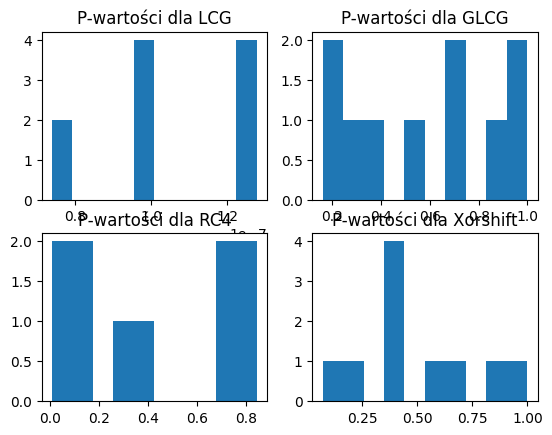

In [43]:
def second_level_testing_runs_test(data, sequence_length):
    seq_num = len(data) // sequence_length  # ilość podciągów podanej długości
    p_values = []
    for i in range(seq_num):
        seq = data[i * sequence_length : (i + 1) * sequence_length]  # tworzenie podciągów
        try:
            p_value = runs_test(seq)["P-wartość"]  # przeprowadzanie testu
            p_values.append(p_value)
        except ValueError:
            p_values.append(None)
    return p_values


length = 100
p_values3_lcg = second_level_testing_runs_test(test_lcg, length)
p_values3_glcg = second_level_testing_runs_test(test_glcg, length)
p_values3_rc4 = second_level_testing_runs_test(test_rc4, length)
p_values3_xorshift = second_level_testing_runs_test(test_xorshift, length)

# print(f"P-wartości dla wszystkich podciągów - LCG:")
# print(p_values3_lcg)
# print(f"P-wartości dla wszystkich podciągów - GLCG:")
# print(p_values3_glcg)
# print(f"P-wartości dla wszystkich podciągów - RC4:")
# print(p_values3_rc4)
# print(f"P-wartości dla wszystkich podciągów - Xorshift:")
# print(p_values3_xorshift)

plt.subplot(2, 2, 1)
plt.hist(p_values3_lcg)
plt.title("P-wartości dla LCG")

plt.subplot(2, 2, 2)
plt.hist(p_values3_glcg)
plt.title("P-wartości dla GLCG")

plt.subplot(2, 2, 3)
plt.hist(p_values3_rc4)
plt.title("P-wartości dla RC4")

plt.subplot(2, 2, 4)
plt.hist(p_values3_xorshift)
plt.title("P-wartości dla Xorshift")

# 4. Frequency monobit test

In [113]:
import numpy as np
from scipy.stats import norm
import requests

def freq_monobit(data):
  seq = 2 * np.array(data) - 1
  S_obs = sum(seq) / np.sqrt(len(seq))
  p_value = 2*(1- norm.cdf(abs(S_obs)))
  return {
        "Statystyka": S_obs,
        "P-wartość": p_value
    }

## 4.1 Liczba $\pi$

In [118]:
url_pi = "http://www.math.uni.wroc.pl/~rolski/Zajecia/data.pi"
pi_bin = requests.get(url_pi)
bits_pi = pi_bin.text.split("\n")
pi_list = [bit.strip() for bit in bits_pi]
bits_pi_final = "".join(pi_list)
pi_list_help = list(bits_pi_final)
pi_list_final = [int(bit) for bit in pi_list_help]
#print(pi_list_final[1:10])

fmt_pi = freq_monobit(pi_list_final)
print("Statystyka testu frequency monobit dla liczby pi:", fmt_pi["Statystyka"])
print("P-wartość testu frequency monobit dla liczby pi:", fmt_pi["P-wartość"])

Statystyka testu frequency monobit dla liczby pi: -0.5047693581663462
P-wartość testu frequency monobit dla liczby pi: 0.6137208398729661


## 4.2 Liczba $e$

In [119]:
url_e = "http://www.math.uni.wroc.pl/~rolski/Zajecia/data.e"
e_bin = requests.get(url_e)
bits_e = e_bin.text.split("\n")
e_list = [bit.strip() for bit in bits_e]
bits_e_final = "".join(e_list)
e_list_help = list(bits_e_final)
e_list_final = [int(bit) for bit in e_list_help]
#print(e_list_final[1:10])

fmt_e = freq_monobit(e_list_final)
print("Statystyka testu frequency monobit dla liczby e:", fmt_e["Statystyka"])
print("P-wartość testu frequency monobit dla liczby e:", fmt_e["P-wartość"])

Statystyka testu frequency monobit dla liczby e: 0.09177624693933566
P-wartość testu frequency monobit dla liczby e: 0.926875816594998


## 4.3 Liczba $\sqrt2$

In [120]:
url_s2 = "http://www.math.uni.wroc.pl/~rolski/Zajecia/data.sqrt2"
s2_bin = requests.get(url_s2)
bits_s2 = s2_bin.text.split("\n")
s2_list = [bit.strip() for bit in bits_s2]
bits_s2_final = "".join(s2_list)
s2_list_help = list(bits_s2_final)
s2_list_final = [int(bit) for bit in s2_list_help]
#print(s2_list_final[1:10])

fmt_s2 = freq_monobit(s2_list_final)
print("Statystyka testu frequency monobit dla pierwiastka z dwóch:", fmt_s2["Statystyka"])
print("P-wartość testu frequency monobit dla pierwiastka z dwóch:", fmt_s2["P-wartość"])

Statystyka testu frequency monobit dla pierwiastka z dwóch: -0.23043807059061344
P-wartość testu frequency monobit dla pierwiastka z dwóch: 0.8177513809816284
